# Simran Kaur

# 311443

# DDA Lab 7 Report

In [1]:
import torch
from torch.nn import Module
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Network Analysis: Image Classification - Part 2

### The Network has three convolution layer, two max pool and three fully connected layers with ReLU as activation function. Since the Loss here used is CrossEntropy so there wasn't any need for the softmax layer. The input and output channels are selected after some experiments.

In [2]:
class CNNetwork(Module):
    def __init__(self, input_channels):
        super(CNNetwork, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 10, kernel_size = 5)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(10, 30, kernel_size = 5)
        self.conv3 = nn.Conv2d(30, 60, kernel_size = 5)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(540, 270)
        self.fc2 = nn.Linear(270, 130)
        self.fc3 = nn.Linear(130, 10)
        

    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = self.pool1(y)
        y = F.relu(self.conv2(y))
        y = F.relu(self.conv3(y))
        y = self.pool2(y)
        y = y.view(-1, 60*3*3)
        y = F.relu(self.fc1(y))
        y = F.relu(self.fc2(y))
        y = self.fc3(y)
        return y

In [3]:
CifarTrain = torchvision.datasets.CIFAR10(root = './data', train = True, transform = transforms.ToTensor(), download = True)
CifarTest = torchvision.datasets.CIFAR10(root = './data', train = False, transform = transforms.ToTensor(), download = True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
batch_size = 128
epochs = 10
learning_rate = 10**(-3)
CifarTrainHalf = torch.utils.data.Subset(CifarTrain, range(len(CifarTrain)//2))

In [7]:
train_loader = DataLoader(CifarTrainHalf, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(CifarTest, batch_size = 64, shuffle = True)

In [ ]:
ModelCNN = CNNetwork(3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ModelCNN.parameters(),lr = learning_rate)
writer = SummaryWriter(f'runs/Cifar/Network')
step = 0
for epoch in range(epochs):
    total_loss = 0
    correct_pred = 0
    sample_size = 0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        yhat = ModelCNN(batch[0])
        loss = criterion(yhat.squeeze(), batch[1].squeeze())
        total_loss += loss.item()
        pred = torch.max(yhat.data, 1)[1]
        sample_size = batch[1].size(0)
        correct_pred += (pred == batch[1]).sum().item()
        loss.backward()
        optimizer.step() 
        if (i + 1) % 50 == 0:
            writer.add_scalar('Loss on Minibatches', loss.item(), step + 1)
            writer.add_scalar('Accuracy on minibatches',((pred == batch[1]).sum().item()/sample_size)*100 , 
                              step + 1)
            step += 1
    accuracy = (correct_pred/len(CifarTrainHalf))*100
    writer.add_scalar('Train Loss', np.sqrt(total_loss/len(CifarTrainHalf)), epoch + 1)
    writer.add_scalar('Train accuracy', accuracy, epoch + 1)
    
    with torch.no_grad():
        test_pred = 0
        test_loss = 0
        for i, (img, label) in enumerate(test_loader):
            optimizer.zero_grad()
            output = ModelCNN(img)
            loss = criterion(output.squeeze(), label.squeeze())
            test_loss += loss.item()
            pred = torch.max(output.data, 1)[1]
            test_pred += (pred == label).sum().item()
        accuracy = (test_pred/len(CifarTest))*100   
        writer.add_scalar('Test Loss', np.sqrt(test_loss/len(CifarTest)), epoch + 1)
        writer.add_scalar('Test accuracy', accuracy, epoch + 1)
    
writer.close()
writer.flush()

### For batches we can see see the trend in loss and accuracy, as the model sees more and more data, loss is decreased and accuracy is increased.

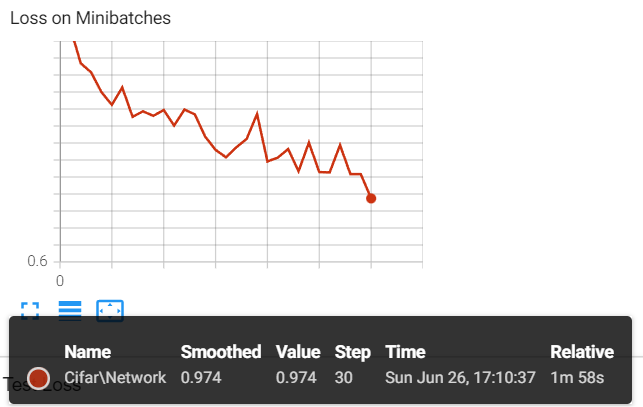

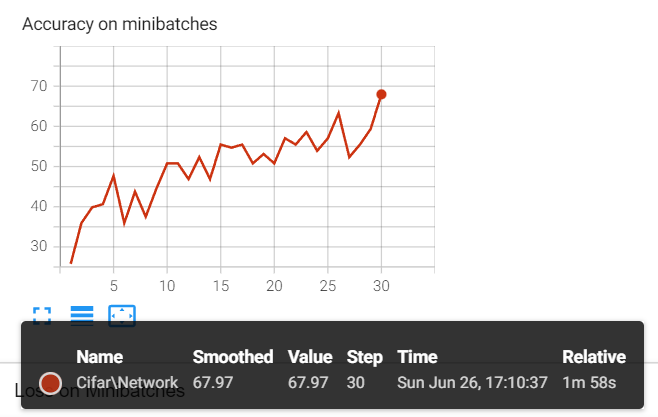

# Training and Test Loss

### For the 10th epoch, the test loss as seen below is very high (0.14) as compared to the training loss which is 0.09

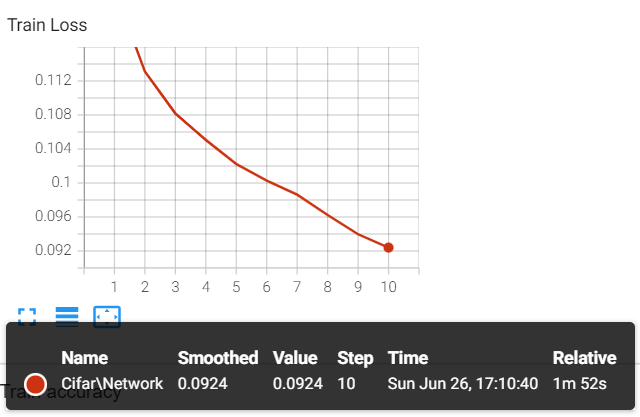

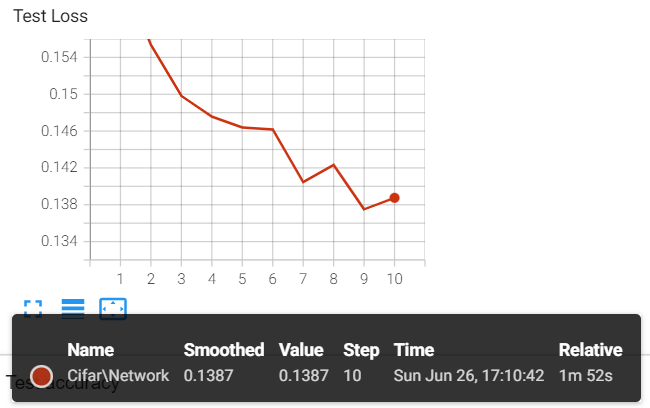

# Training and Test Accuracy

### Also on comparing accuracy we see that training accuracy is more than the test accuracy

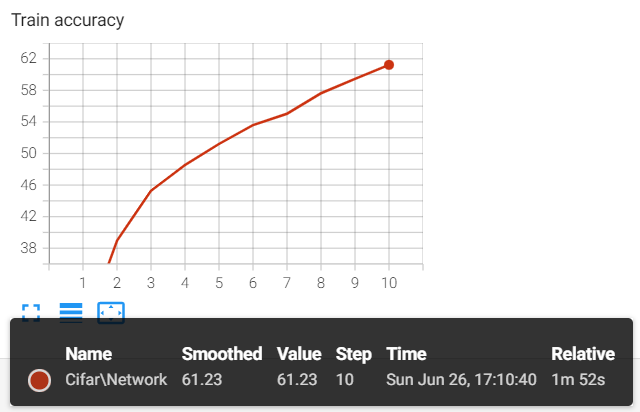

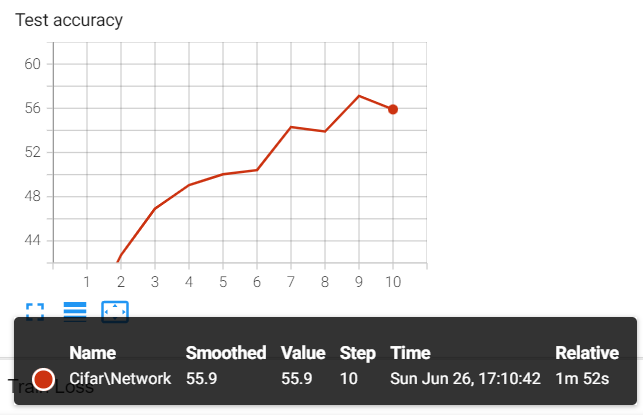

# Now we will see approaches to deal with overfiting as seen above

# Normalization Effect

###  mean and standard deviation for Normalization

In [8]:
R_total_mean, G_total_mean, B_total_mean = 0, 0, 0
R_total_std, G_total_std, B_total_std = 0, 0, 0
for img, label in CifarTrain:
    R_mean, G_mean ,B_mean = torch.mean(img, dim = [1,2])
    R_std, G_std ,B_std = torch.std(img, dim = [1,2])
    R_total_mean += R_mean
    G_total_mean += G_mean
    B_total_mean += B_mean
    R_total_std += R_std
    G_total_std += G_std
    B_total_std += B_std
print(R_total_mean/len(CifarTrain), G_total_mean/len(CifarTrain), B_total_mean/len(CifarTrain))
print(R_total_std/len(CifarTrain), G_total_std/len(CifarTrain), B_total_std/len(CifarTrain))

tensor(0.4914) tensor(0.4822) tensor(0.4465)
tensor(0.2023) tensor(0.1994) tensor(0.2010)


### Transformations defined for augmentation, normalization and both as below

In [ ]:
transformAug = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor()
                               ])

transformNorm = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                               ])

transformBoth = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                               ])

## 1. Augmentation

### The general idea is to increase dataset by appending more images with some changes such as change in contrast, rotation etc.

In [ ]:
CifarTrainAug = torchvision.datasets.CIFAR10(root = './data', train = True, 
                                             transform = transformAug, download = True)
CifarTestAug = torchvision.datasets.CIFAR10(root = './data', train = False,
                                            transform = transformAug, download = True)

In [ ]:
AugmentedDataTrain = torch.utils.data.ConcatDataset([CifarTrain, CifarTrainAug])
AugmentedDataTest = torch.utils.data.ConcatDataset([CifarTest, CifarTestAug])

In [ ]:
train_loaderAug = DataLoader(AugmentedDataTrain, batch_size = batch_size, shuffle=True)
test_loaderAug = DataLoader(AugmentedDataTest, batch_size = 64, shuffle = True)

In [ ]:
ModelCNNAug = CNNetwork(3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ModelCNNAug.parameters(),lr = learning_rate)
writer = SummaryWriter(f'runs/Cifar/Augmentation')
step = 0
for epoch in range(epochs):
    total_loss = 0
    correct_pred = 0
    sample_size = 0
    for i, batch in enumerate(train_loaderAug):
        optimizer.zero_grad()
        yhat = ModelCNNAug(batch[0])
        loss = criterion(yhat.squeeze(), batch[1].squeeze())
        total_loss += loss.item()
        pred = torch.max(yhat.data, 1)[1]
        sample_size = batch[1].size(0)
        correct_pred += (pred == batch[1]).sum().item()
        loss.backward()
        optimizer.step() 
        if (i + 1) % 50 == 0:
            writer.add_scalar('Loss on Minibatches', loss.item(), step + 1)
            writer.add_scalar('Accuracy on minibatches',((pred == batch[1]).sum().item()/sample_size)*100 , 
                              step + 1)
            step += 1
    accuracy = (correct_pred/len(AugmentedDataTrain))*100
    writer.add_scalar('Train Loss', np.sqrt(total_loss/len(AugmentedDataTrain)), epoch + 1)
    writer.add_scalar('Train accuracy', accuracy, epoch + 1)
    
    with torch.no_grad():
        test_pred = 0
        test_loss = 0
        for i, (img, label) in enumerate(test_loaderAug):
            optimizer.zero_grad()
            output = ModelCNNAug(img)
            loss = criterion(output.squeeze(), label.squeeze())
            test_loss += loss.item()
            pred = torch.max(output.data, 1)[1]
            test_pred += (pred == label).sum().item()
        accuracy = (test_pred/len(AugmentedDataTest))*100   
        writer.add_scalar('Test Loss', np.sqrt(test_loss/len(AugmentedDataTest)), epoch + 1)
        writer.add_scalar('Test accuracy', accuracy, epoch + 1)
    
writer.close()
writer.flush()

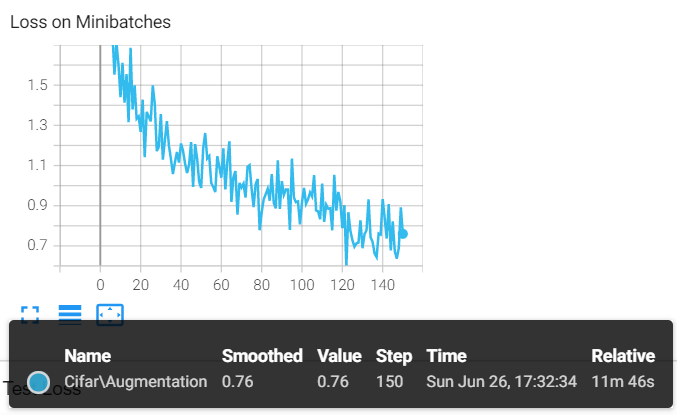

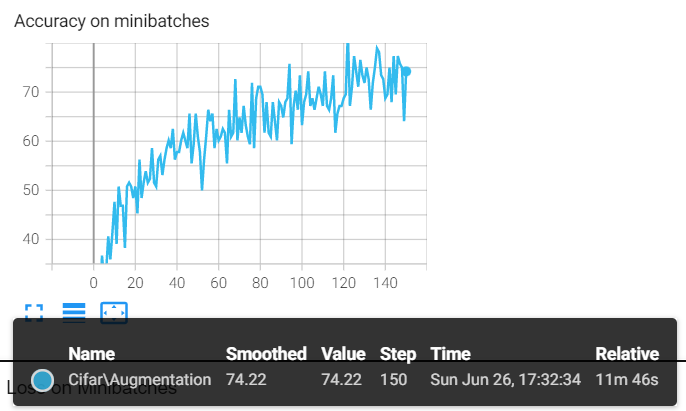

# Training and Test Loss
## Comparison with baseline

### The Network seems to work even better after Augmentation to the dataset. Not only the loss on training has decreased but also on the test itself.

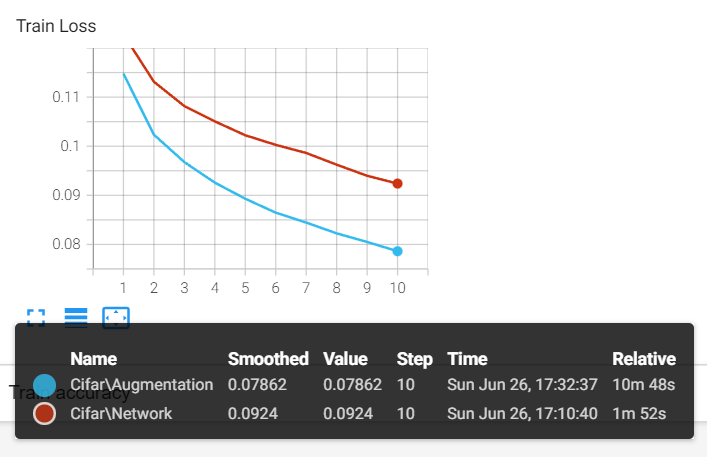

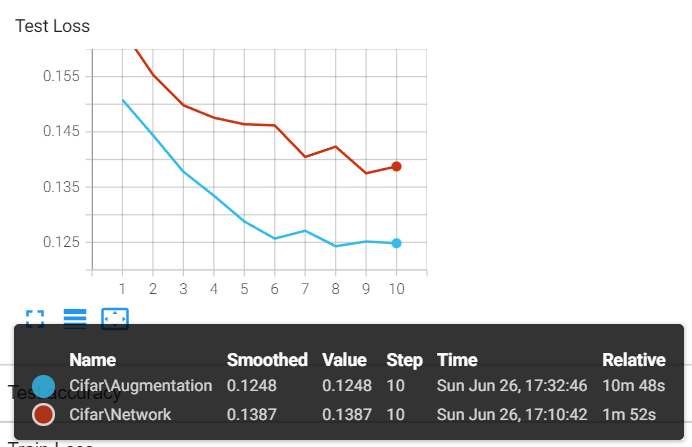

# Training and test accuracy
## comparison with baseline

### After augmentation, the training and test accuracy have both risen.

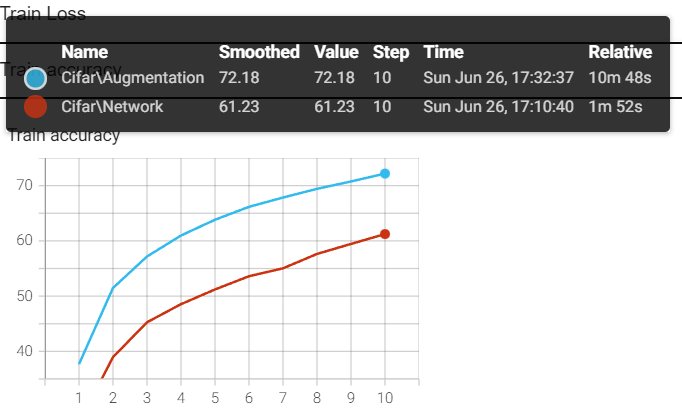

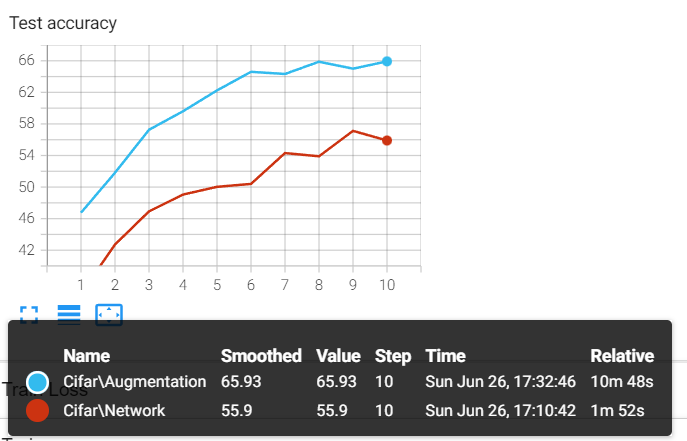

# Normalization

### Normalizing dataset also has huge impact on the performance of the model.

In [ ]:
CifarTrainNorm = torchvision.datasets.CIFAR10(root = './data', train = True, 
                                             transform = transformNorm, download = True)
CifarTestNorm = torchvision.datasets.CIFAR10(root = './data', train = False,
                                            transform = transformNorm, download = True)

In [ ]:
train_loaderNorm = DataLoader(CifarTrainNorm, batch_size = batch_size, shuffle=True)
test_loaderNorm = DataLoader(CifarTestNorm, batch_size = 64, shuffle = True)

In [ ]:
ModelCNNnorm = CNNetwork(3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ModelCNNnorm.parameters(),lr = learning_rate)
writer = SummaryWriter(f'runs/Cifar/Normalization')
step = 0
for epoch in range(epochs):
    total_loss = 0
    correct_pred = 0
    sample_size = 0
    for i, batch in enumerate(train_loaderNorm):
        optimizer.zero_grad()
        yhat = ModelCNNnorm(batch[0])
        loss = criterion(yhat.squeeze(), batch[1].squeeze())
        total_loss += loss.item()
        pred = torch.max(yhat.data, 1)[1]
        sample_size = batch[1].size(0)
        correct_pred += (pred == batch[1]).sum().item()
        loss.backward()
        optimizer.step() 
        if (i + 1) % 50 == 0:
            writer.add_scalar('Loss on Minibatches', loss.item(), step + 1)
            writer.add_scalar('Accuracy on minibatches',((pred == batch[1]).sum().item()/sample_size)*100 , 
                              step + 1)
            step += 1
    accuracy = (correct_pred/len(CifarTrainNorm))*100
    writer.add_scalar('Train Loss', np.sqrt(total_loss/len(CifarTrainNorm)), epoch + 1)
    writer.add_scalar('Train accuracy', accuracy, epoch + 1)
    
    with torch.no_grad():
        test_pred = 0
        test_loss = 0
        for i, (img, label) in enumerate(test_loaderNorm):
            optimizer.zero_grad()
            output = ModelCNNnorm(img)
            loss = criterion(output.squeeze(), label.squeeze())
            test_loss += loss.item()
            pred = torch.max(output.data, 1)[1]
            test_pred += (pred == label).sum().item()
        accuracy = (test_pred/len(CifarTestNorm))*100   
        writer.add_scalar('Test Loss', np.sqrt(test_loss/len(CifarTestNorm)), epoch + 1)
        writer.add_scalar('Test accuracy', accuracy, epoch + 1)
    
writer.close()
writer.flush()

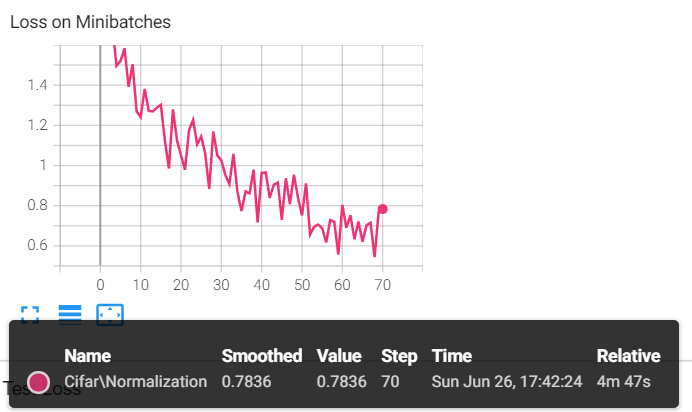

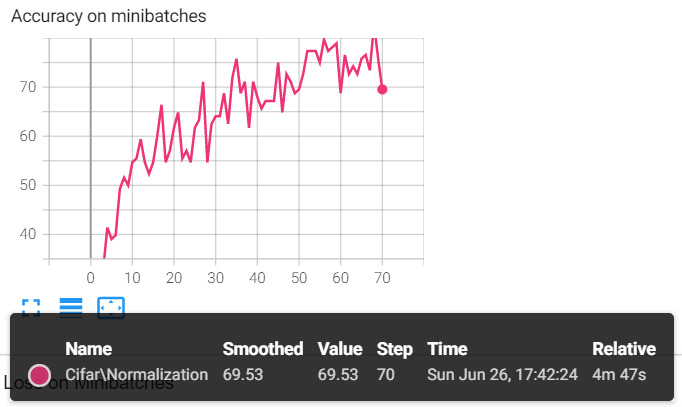

# Training and Test Loss
## Comparison with baseline

### After normalization both training and test loss has decreased as can be seen below.

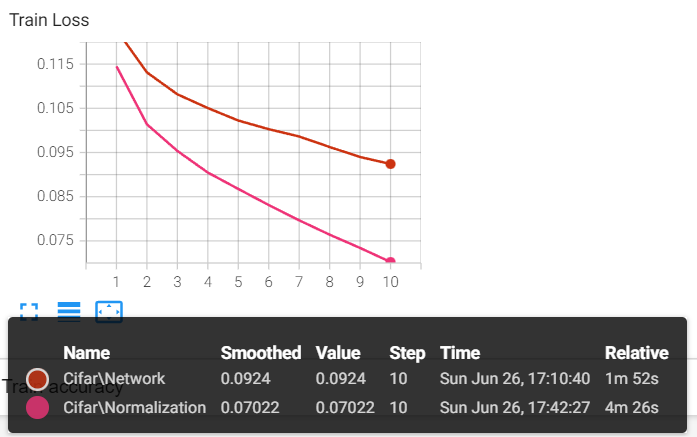

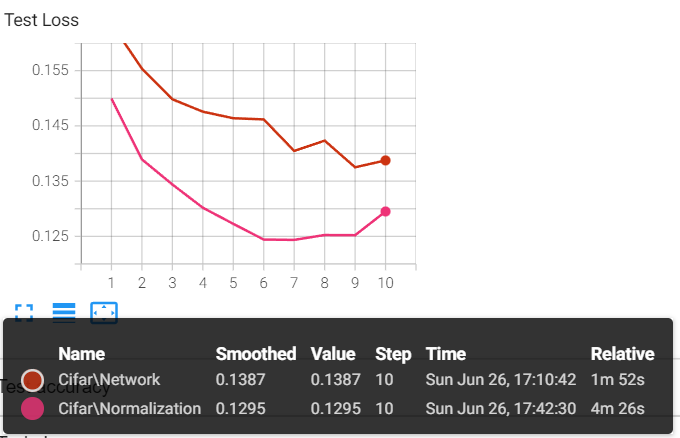

# Training and test accuracy
## comparison with baseline

### The training accuracy has increased from around 60% to 77.5% while the test accuracy from 60% to 66% over a range of 10 epochs.

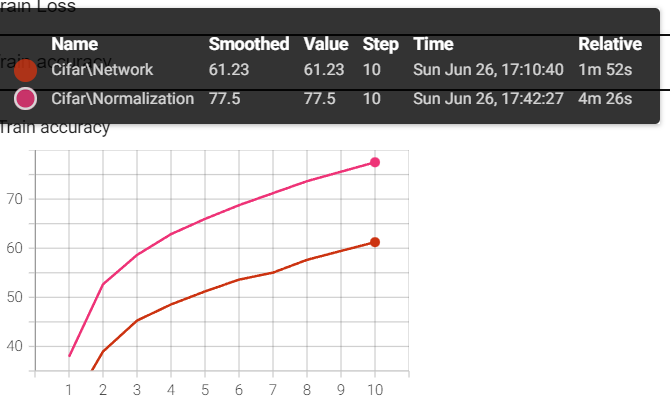

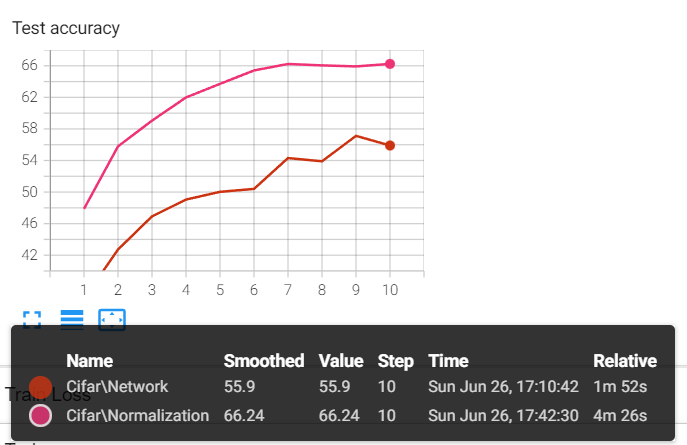

# Augmentation + Normalization

### Now both the Augmentation and normalization has been applied to the dataset.

In [ ]:
CifarTrainAugNorm = torchvision.datasets.CIFAR10(root = './data', train = True, 
                                             transform = transformBoth, download = True)
CifarTestAugNorm = torchvision.datasets.CIFAR10(root = './data', train = False,
                                            transform = transformBoth, download = True)

In [ ]:
AugmentedTrain = torch.utils.data.ConcatDataset([CifarTrainAugNorm, CifarTrainNorm])
AugmentedTest = torch.utils.data.ConcatDataset([CifarTestAugNorm, CifarTestNorm])

In [ ]:
train_loaderAugNorm = DataLoader(AugmentedTrain, batch_size = batch_size, shuffle=True)
test_loaderAugNorm = DataLoader(AugmentedTest, batch_size = 64, shuffle = True)

In [ ]:
Model = CNNetwork(3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Model.parameters(),lr = learning_rate)
writer = SummaryWriter(f'runs/Cifar/Norm_Aug')
step = 0
for epoch in range(epochs):
    total_loss = 0
    correct_pred = 0
    sample_size = 0
    for i, batch in enumerate(train_loaderAugNorm):
        optimizer.zero_grad()
        yhat = Model(batch[0])
        loss = criterion(yhat.squeeze(), batch[1].squeeze())
        total_loss += loss.item()
        pred = torch.max(yhat.data, 1)[1]
        sample_size = batch[1].size(0)
        correct_pred += (pred == batch[1]).sum().item()
        loss.backward()
        optimizer.step() 
        if (i + 1) % 50 == 0:
            writer.add_scalar('Loss on Minibatches', loss.item(), step + 1)
            writer.add_scalar('Accuracy on minibatches',((pred == batch[1]).sum().item()/sample_size)*100 , 
                              step + 1)
            step += 1
    accuracy = (correct_pred/len(AugmentedTrain))*100
    writer.add_scalar('Train Loss', np.sqrt(total_loss/len(AugmentedTrain)), epoch + 1)
    writer.add_scalar('Train accuracy', accuracy, epoch + 1)
    
    with torch.no_grad():
        test_pred = 0
        test_loss = 0
        for i, (img, label) in enumerate(test_loaderAugNorm):
            optimizer.zero_grad()
            output = Model(img)
            loss = criterion(output.squeeze(), label.squeeze())
            test_loss += loss.item()
            pred = torch.max(output.data, 1)[1]
            test_pred += (pred == label).sum().item()
        accuracy = (test_pred/len(AugmentedTest))*100   
        writer.add_scalar('Test Loss', np.sqrt(test_loss/len(AugmentedTest)), epoch + 1)
        writer.add_scalar('Test accuracy', accuracy, epoch + 1)
    
writer.close()
writer.flush()

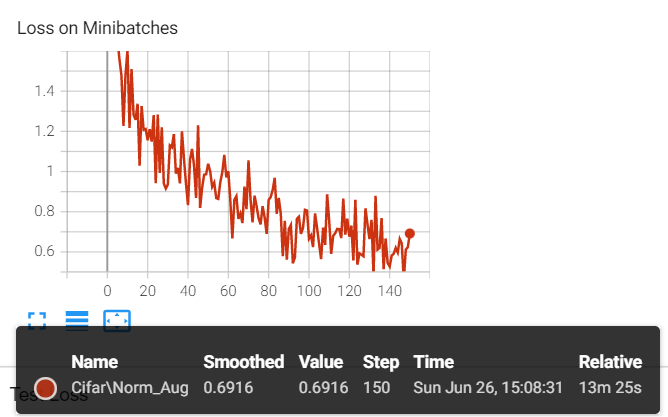

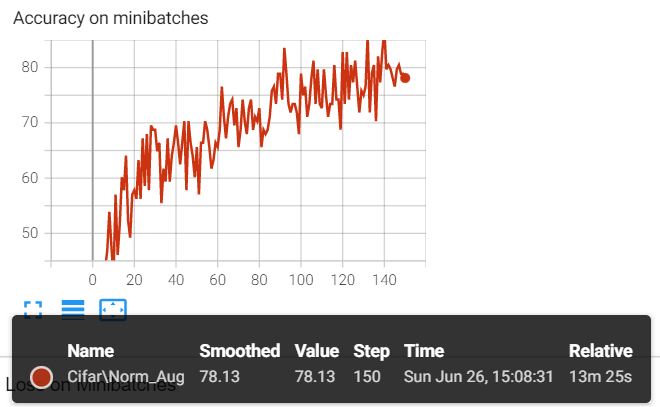

# Training and Test Loss
## Comparison with baseline

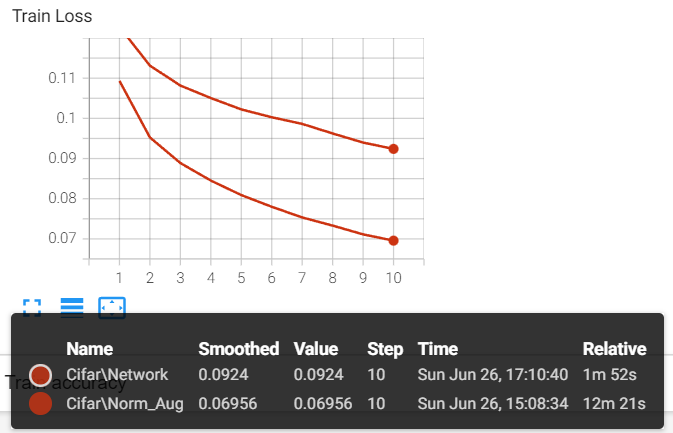

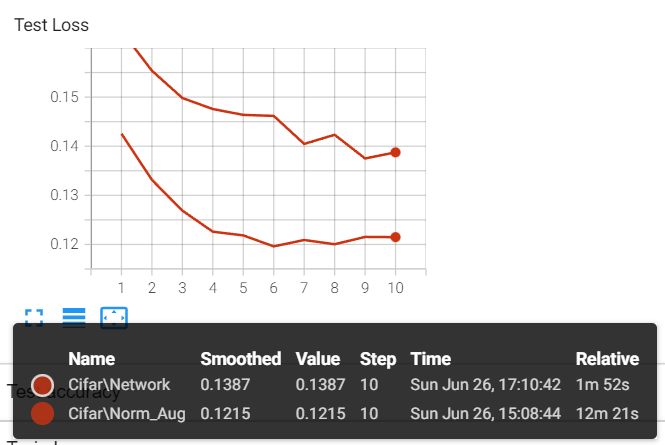

# Training and Test accuracy
## Comparison with baseline

### This has resulted in the higher accuracy increase so far with train accuracy around 79% and test accuracy 70% over a range of 10 epochs.

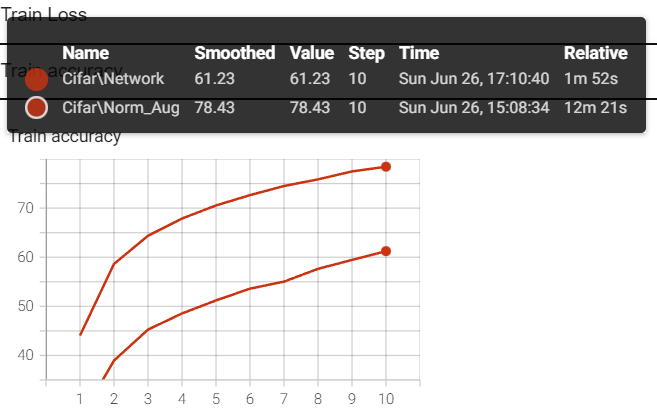

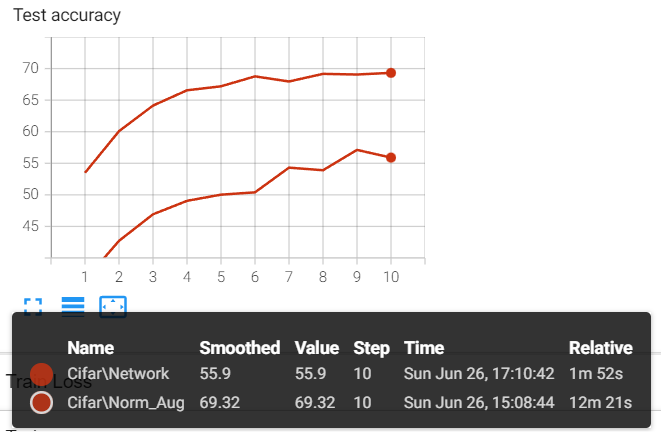

# Network Regularization

### So far the modification to the dataset has resulted in the increase in the model accuracy as well as decrease in the loss. These all modification changes from model to model as well as the amount of training data available. Now we will see how can we make changes in the model itself, by dropping some neurons or by penalising the weights associated with them to improve model efficiency.

## Dropout

### For the fully connected layers, we give a probability for the number of neurons that can be dropped that the model over training finds to be not that important in order to reduce complexity as well as increase efficiency.

In [ ]:
class CNNDropout(Module):
    def __init__(self, input_channels, dropProb1, dropProb2):
        super(CNNetwork, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 10, kernel_size = 5)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(10, 30, kernel_size = 5)
        self.conv3 = nn.Conv2d(30, 60, kernel_size = 5)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(540, 270)
        self.dropout1 = nn.Dropout(dropProb1)
        self.fc2 = nn.Linear(270, 130)
        self.dropout2 = nn.Dropout(dropProb2)
        self.fc3 = nn.Linear(130, 10)
        

    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = self.pool1(y)
        y = F.relu(self.conv2(y))
        y = F.relu(self.conv3(y))
        y = self.pool2(y)
        y = y.view(-1, 60*3*3)
        y = F.relu(self.fc1(y))
        y = self.dropout1(y)
        y = F.relu(self.fc2(y))
        y = self.dropout2(y)
        y = self.fc3(y)
        return y

In [ ]:
ModelD = CNNDropout(3, 0.3, 0.2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ModelD.parameters(),lr = learning_rate)
writer = SummaryWriter(f'runs/Cifar/Dropout')
step = 0
for epoch in range(epochs):
    total_loss = 0
    correct_pred = 0
    sample_size = 0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        yhat = ModelD(batch[0])
        loss = criterion(yhat.squeeze(), batch[1].squeeze())
        total_loss += loss.item()
        pred = torch.max(yhat.data, 1)[1]
        sample_size = batch[1].size(0)
        correct_pred += (pred == batch[1]).sum().item()
        loss.backward()
        optimizer.step() 
        if (i + 1) % 50 == 0:
            writer.add_scalar('Loss on Minibatches', loss.item(), step + 1)
            writer.add_scalar('Accuracy on minibatches',((pred == batch[1]).sum().item()/sample_size)*100 , 
                              step + 1)
            step += 1
    accuracy = (correct_pred/len(CifarTrain))*100
    writer.add_scalar('Train Loss', np.sqrt(total_loss/len(CifarTrain)), epoch + 1)
    writer.add_scalar('Train accuracy', accuracy, epoch + 1)
    
    with torch.no_grad():
        test_pred = 0
        test_loss = 0
        for i, (img, label) in enumerate(test_loader):
            optimizer.zero_grad()
            output = ModelD(img)
            loss = criterion(output.squeeze(), label.squeeze())
            test_loss += loss.item()
            pred = torch.max(output.data, 1)[1]
            test_pred += (pred == label).sum().item()
        accuracy = (test_pred/len(CifarTest))*100   
        writer.add_scalar('Test Loss', np.sqrt(test_loss/len(CifarTest)), epoch + 1)
        writer.add_scalar('Test accuracy', accuracy, epoch + 1)
    
writer.close()
writer.flush()

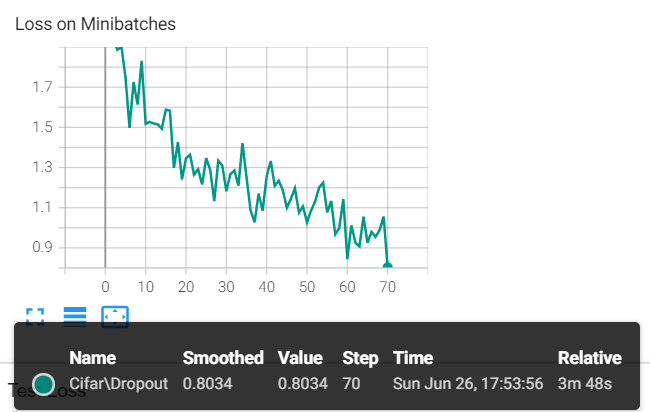

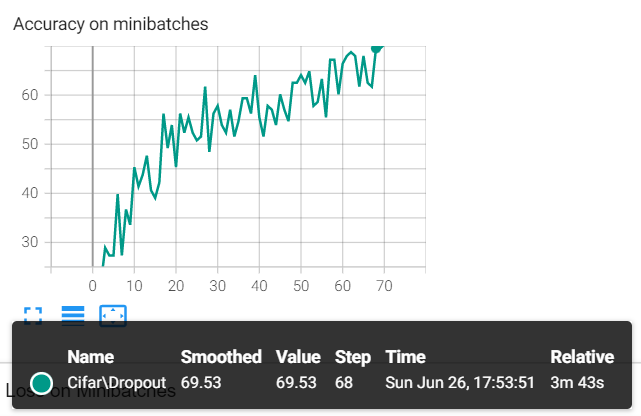

# Training and Test Loss
## Comparison with baseline

### Since the probabilities chosen here are random, the efficiency can be increased more by adjusting them. For the case, we can still see the decrease in the training and test loss as compared to the baseline.

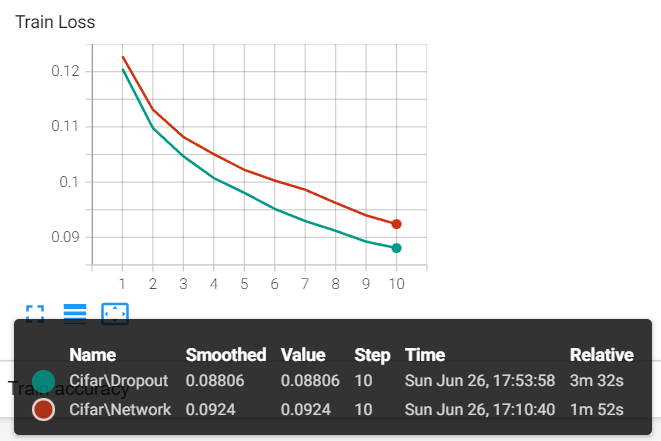

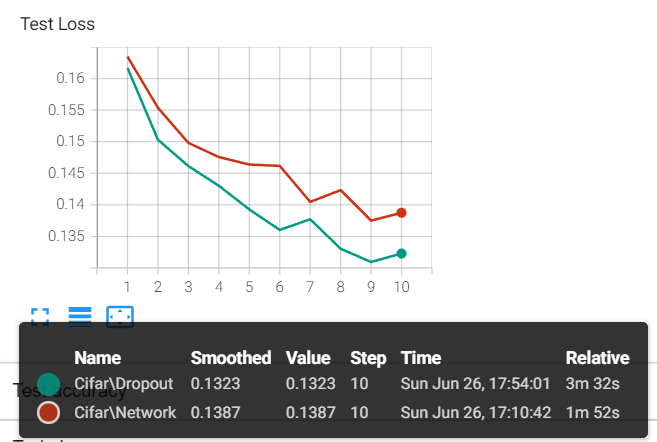

# Training and Test accuracy
## Comparison with baseline

### The accuracy is though not as good as the one after Aigmentation+Normalization but it is better than the baseline.

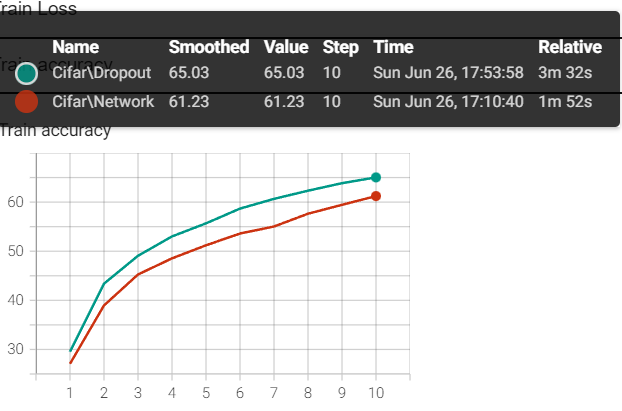

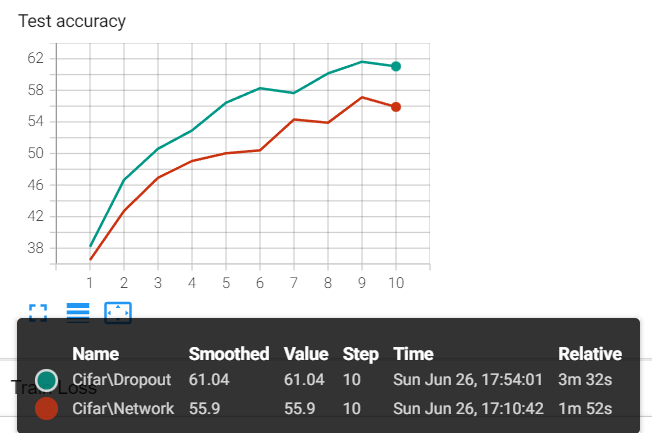

## L1 Regularization

### After the first fully connected layer, L1 regularization is applied to the parameters obtained from that layer. Since this layer has the maximum input among other FC layers and thus it is chosen randomly. The results may be better by using it on other or all layers. For the experiment part I have chosen this particular layer.

In [ ]:
lambda1, lambda2 = 0.5, 0.5

In [ ]:
class CNNL1(Module):
    def __init__(self, input_channels):
        super(CNNL1, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 10, kernel_size = 5)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(10, 30, kernel_size = 5)
        self.conv3 = nn.Conv2d(30, 60, kernel_size = 5)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(540, 270)
        self.fc2 = nn.Linear(270, 130)
        self.fc3 = nn.Linear(130, 10)
        

    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = self.pool1(y)
        y = F.relu(self.conv2(y))
        y = F.relu(self.conv3(y))
        y = self.pool2(y)
        y = y.view(-1, 60*3*3)
        y1 = F.relu(self.fc1(y))
        y2 = F.relu(self.fc2(y1))
        out = self.fc3(y2)
        return out, y1

In [ ]:
ModelL1 = CNNL1(3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ModelL1.parameters(),lr = learning_rate)
writer = SummaryWriter(f'runs/Cifar/L1')
step = 0
for epoch in range(epochs):
    total_loss = 0
    correct_pred = 0
    sample_size = 0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        yhat, y1 = ModelL1(batch[0])
        entropyloss = criterion(yhat.squeeze(), batch[1].squeeze())
        y1_params = torch.cat([x.view(-1) for x in ModelL1.fc1.parameters()])
        l1_regularization = lambda1*torch.norm(y1_params, 1)
        loss = entropyloss + l1_regularization
        total_loss += loss.item()
        pred = torch.max(yhat.data, 1)[1]
        sample_size = batch[1].size(0)
        correct_pred += (pred == batch[1]).sum().item()
        loss.backward()
        optimizer.step() 
        if (i + 1) % 50 == 0:
            writer.add_scalar('Loss on Minibatches', loss.item(), step + 1)
            writer.add_scalar('Accuracy on minibatches',((pred == batch[1]).sum().item()/sample_size)*100 , 
                              step + 1)
            step += 1
    accuracy = (correct_pred/len(CifarTrain))*100
    writer.add_scalar('Train Loss', np.sqrt(total_loss/len(CifarTrain)), epoch + 1)
    writer.add_scalar('Train accuracy', accuracy, epoch + 1)
    
    with torch.no_grad():
        test_pred = 0
        test_loss = 0
        for i, (img, label) in enumerate(test_loader):
            optimizer.zero_grad()
            output, _ = ModelL1(img)
            loss = criterion(output.squeeze(), label.squeeze())
            test_loss += loss.item()
            pred = torch.max(output.data, 1)[1]
            test_pred += (pred == label).sum().item()
        accuracy = (test_pred/len(CifarTest))*100   
        writer.add_scalar('Test Loss', np.sqrt(test_loss/len(CifarTest)), epoch + 1)
        writer.add_scalar('Test accuracy', accuracy, epoch + 1)
    
writer.close()
writer.flush()

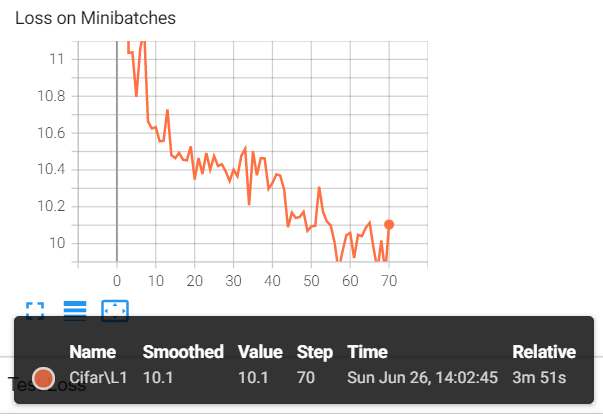

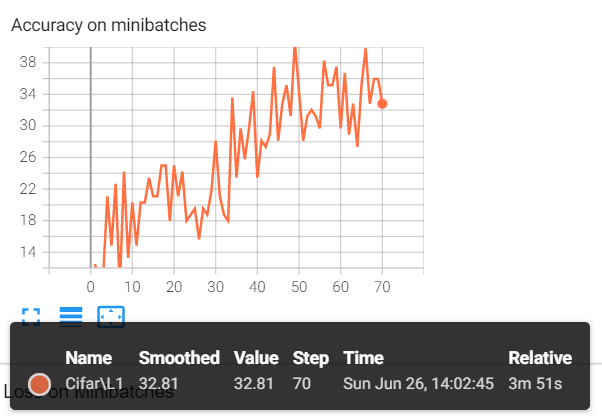

# Training and Test Loss
## comparison with baseline

### Which technique is to be chosen for increasing model efficiency depends on so many factors and thus can be varied from model to model. Here we can see after applying L1 regularization the training and test loss has increased as compared to the baseline. This is may be due to the fact that the model has penalized parameters more as lambda1 is 0.5 and thus the model is performing worse now. Due to lack of time, other values of lambda cannot be experimented.

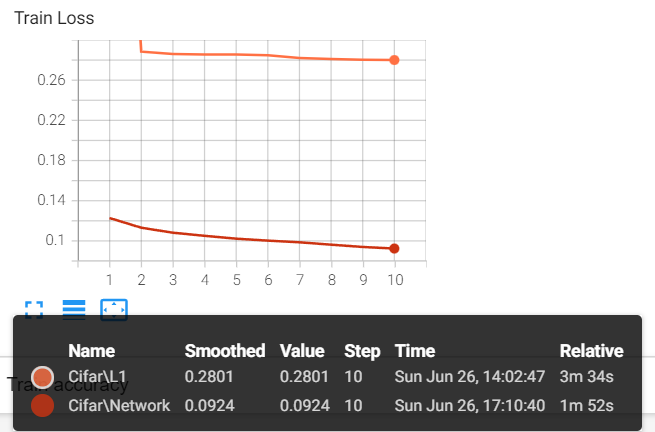

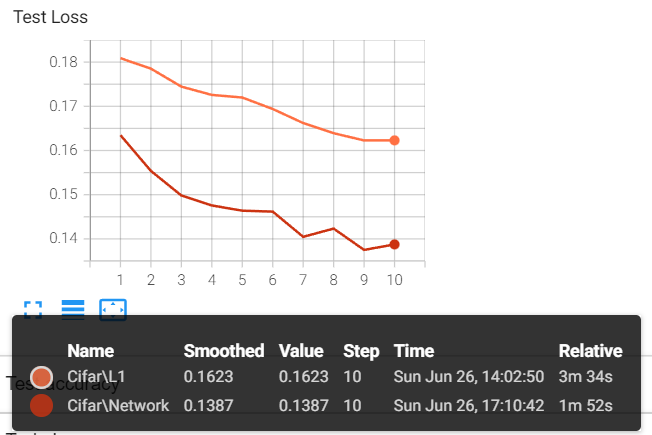

# Training and Test Accuracy
# comparison with baseline

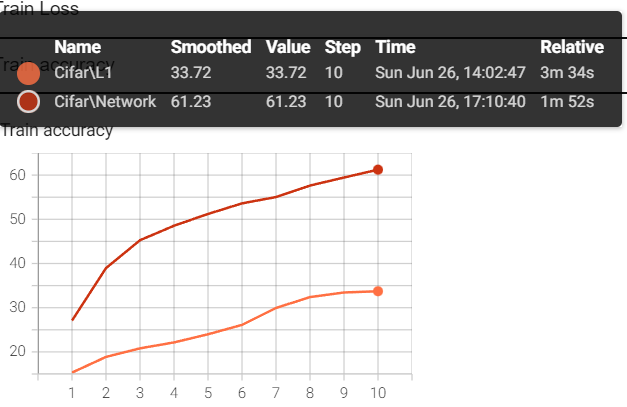

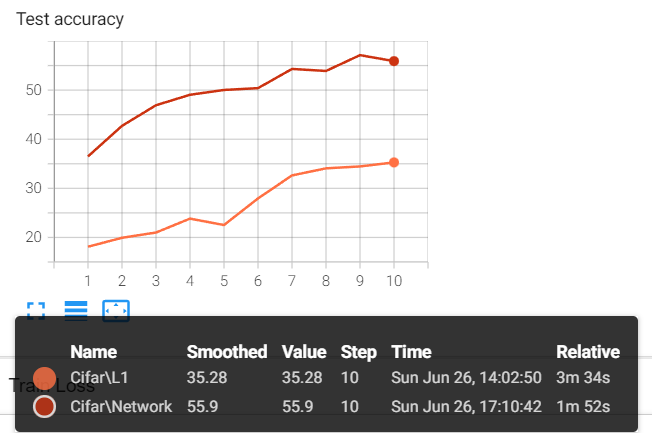

# L2 Regularization

In [ ]:
class CNNL2(Module):
    def __init__(self, input_channels):
        super(CNNL2, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 10, kernel_size = 5)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(10, 30, kernel_size = 5)
        self.conv3 = nn.Conv2d(30, 60, kernel_size = 5)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(540, 270)
        self.fc2 = nn.Linear(270, 130)
        self.fc3 = nn.Linear(130, 10)
        

    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = self.pool1(y)
        y = F.relu(self.conv2(y))
        y = F.relu(self.conv3(y))
        y = self.pool2(y)
        y = y.view(-1, 60*3*3)
        y1 = F.relu(self.fc1(y))
        y2 = F.relu(self.fc2(y1))
        out = self.fc3(y2)
        return out, y1

In [ ]:
ModelL2 = CNNL2(3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ModelL2.parameters(),lr = learning_rate)
writer = SummaryWriter(f'runs/Cifar/L2')
step = 0
for epoch in range(epochs):
    total_loss = 0
    correct_pred = 0
    sample_size = 0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        yhat, y1 = ModelL2(batch[0])
        entropyloss = criterion(yhat.squeeze(), batch[1].squeeze())
        y1_params = torch.cat([x.view(-1) for x in ModelL2.fc1.parameters()])
        l2_regularization = lambda2*torch.norm(y1_params, 2)
        loss = entropyloss + l2_regularization
        total_loss += loss.item()
        pred = torch.max(yhat.data, 1)[1]
        sample_size = batch[1].size(0)
        correct_pred += (pred == batch[1]).sum().item()
        loss.backward()
        optimizer.step() 
        if (i + 1) % 50 == 0:
            writer.add_scalar('Loss on Minibatches', loss.item(), step + 1)
            writer.add_scalar('Accuracy on minibatches',((pred == batch[1]).sum().item()/sample_size)*100 , 
                              step + 1)
            step += 1
    accuracy = (correct_pred/len(CifarTrain))*100
    writer.add_scalar('Train Loss', np.sqrt(total_loss/len(CifarTrain)), epoch + 1)
    writer.add_scalar('Train accuracy', accuracy, epoch + 1)
    
    with torch.no_grad():
        test_pred = 0
        test_loss = 0
        for i, (img, label) in enumerate(test_loader):
            optimizer.zero_grad()
            output, _ = ModelL2(img)
            loss = criterion(output.squeeze(), label.squeeze())
            test_loss += loss.item()
            pred = torch.max(output.data, 1)[1]
            test_pred += (pred == label).sum().item()
        accuracy = (test_pred/len(CifarTest))*100   
        writer.add_scalar('Test Loss', np.sqrt(test_loss/len(CifarTest)), epoch + 1)
        writer.add_scalar('Test accuracy', accuracy, epoch + 1)
    
writer.close()
writer.flush()

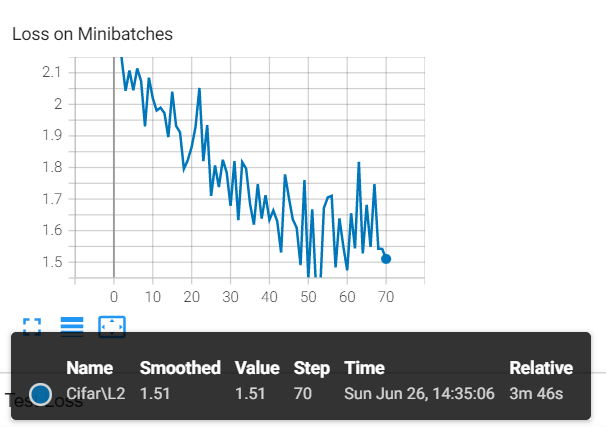

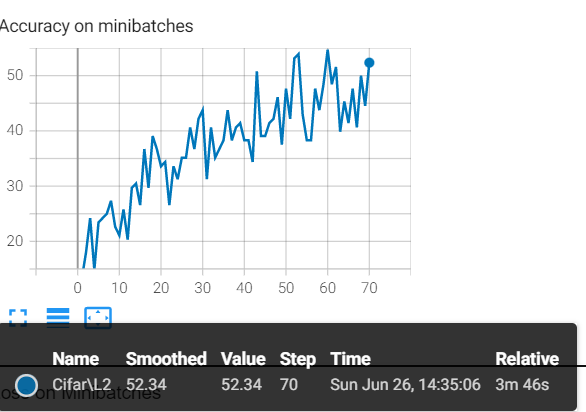

# Training and Test loss
## Comparison with baseline

### As seen above for the L1 regularization, same is observed for the L2 regularization. There has been an increase in  the loss and decrease in the accuracy as compared to the baseline.

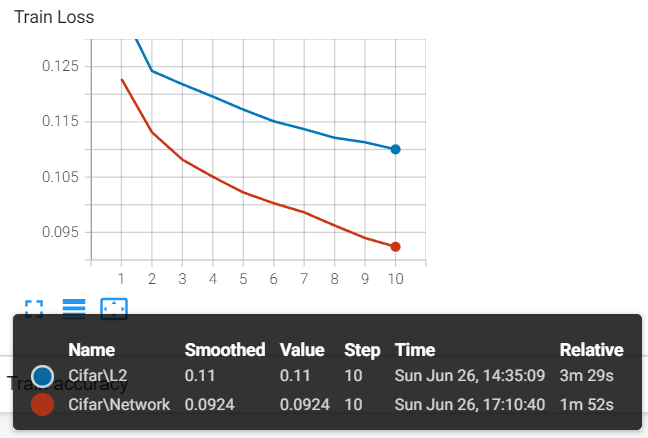

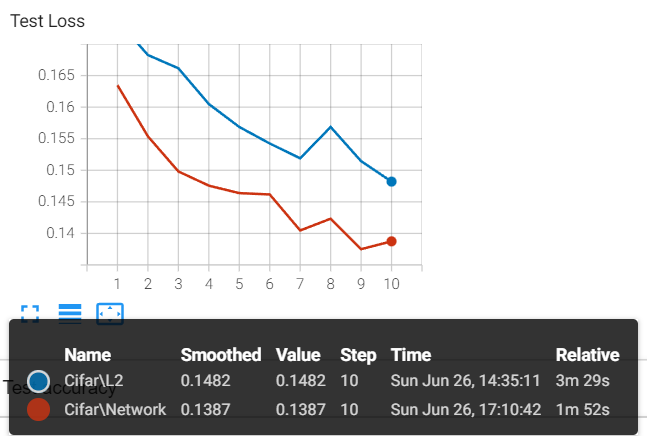

# training and Test Accuracy
## comparison with baseline

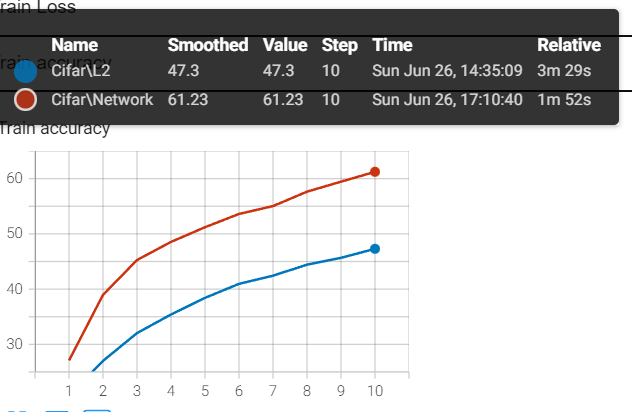

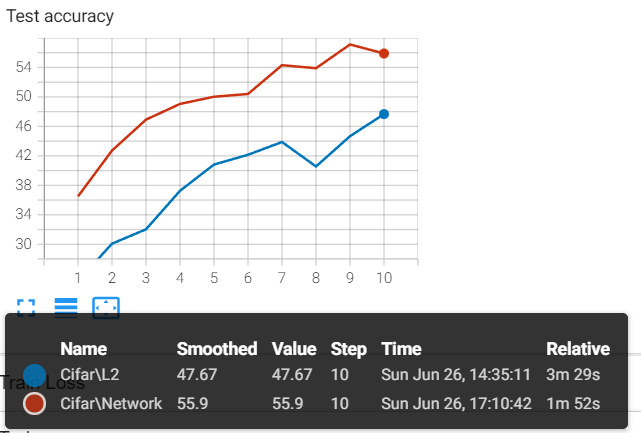

# Optimizers

### Now we will be experimenting with two optimizers and how they response the different learning rates.

In [ ]:
learningRate = [0.01, 0.001, 0.0001]

# Adam Optimizer

In [ ]:
for learning_rate in learningRate:
    Model = CNNetwork(3)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(Model.parameters(),lr = learning_rate)
    writer = SummaryWriter(f'runs/Cifar/Adam {+ learning_rate}')
    step = 0
    for epoch in range(epochs):
        total_loss = 0
        correct_pred = 0
        sample_size = 0
        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()
            yhat = Model(batch[0])
            loss = criterion(yhat.squeeze(), batch[1].squeeze())
            total_loss += loss.item()
            pred = torch.max(yhat.data, 1)[1]
            sample_size = batch[1].size(0)
            correct_pred += (pred == batch[1]).sum().item()
            loss.backward()
            optimizer.step() 
            if (i + 1) % 50 == 0:
                writer.add_scalar('Loss on Minibatches', loss.item(), step + 1)
                writer.add_scalar('Accuracy on minibatches',((pred == batch[1]).sum().item()/sample_size)*100 , 
                                  step + 1)
                step += 1
        
        accuracy = (correct_pred/len(CifarTrain))*100
        writer.add_scalar('Train Loss', np.sqrt(total_loss/len(CifarTrain)), epoch + 1)
        writer.add_scalar('Train accuracy', accuracy, epoch + 1)

        with torch.no_grad():
            test_pred = 0
            test_loss = 0
            for i, (img, label) in enumerate(test_loader):
                optimizer.zero_grad()
                output = Model(img)
                loss = criterion(output.squeeze(), label.squeeze())
                test_loss += loss.item()
                pred = torch.max(output.data, 1)[1]
                test_pred += (pred == label).sum().item()
            accuracy = (test_pred/len(CifarTest))*100   
            writer.add_scalar('Test Loss', np.sqrt(test_loss/len(CifarTest)), epoch + 1)
            writer.add_scalar('Test accuracy', accuracy, epoch + 1)

    writer.close()
    writer.flush()

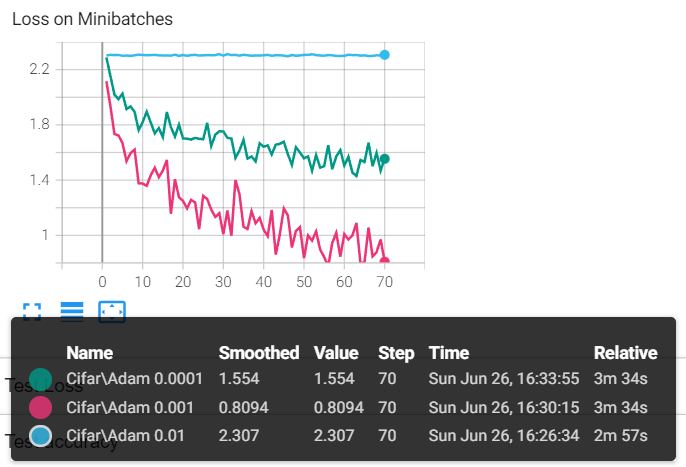

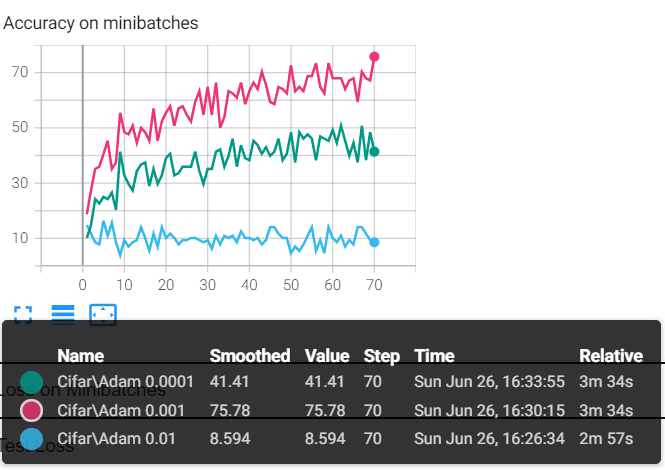

# Training and Test Loss

### As can be seen below, both the training and test loss has decreased more faster when the initial learning rate is neither too big nor too small. For example here three different learning rates were experimented and the results have been found best for learning rate 0.001.

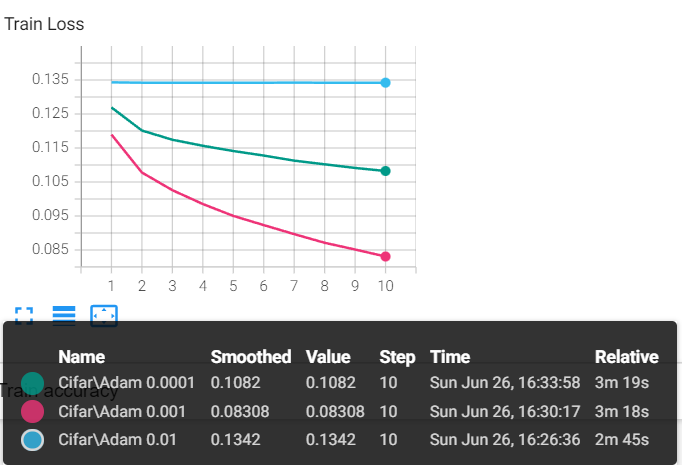

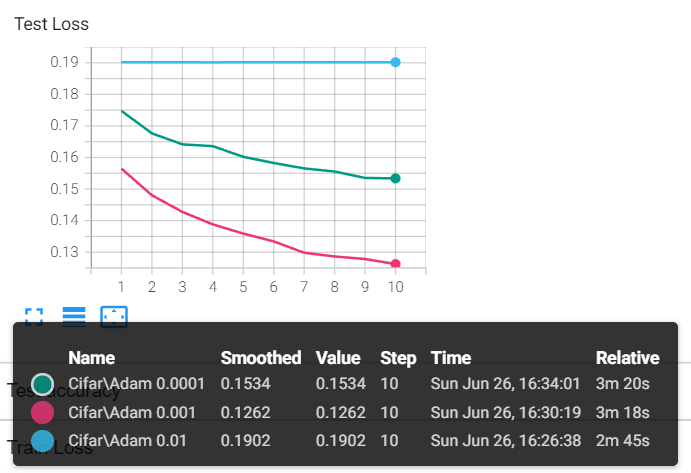

# Training and Test Accuracy

### since the learning rate that has resulted in maximum decrease in loss has also increased the accuracy most.

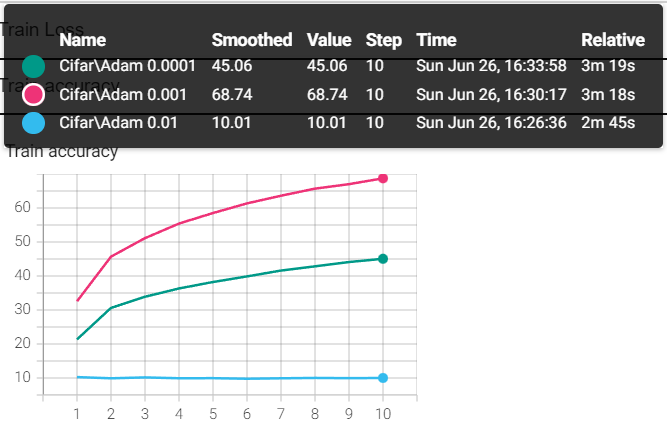

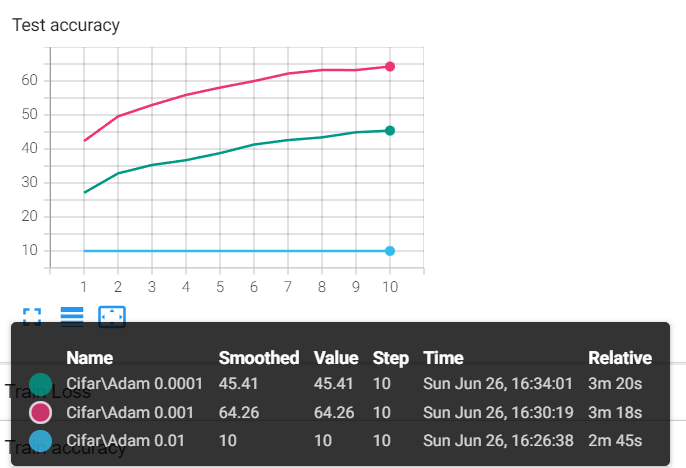

# SGD Optimizer

In [ ]:
for learning_rate in learningRate:
    Model = CNNetwork(3)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(Model.parameters(),lr = learning_rate)
    writer = SummaryWriter(f'runs/Cifar/SGD {+ learning_rate}')
    step = 0
    for epoch in range(epochs):
        total_loss = 0
        correct_pred = 0
        sample_size = 0
        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()
            yhat = Model(batch[0])
            loss = criterion(yhat.squeeze(), batch[1].squeeze())
            total_loss += loss.item()
            pred = torch.max(yhat.data, 1)[1]
            sample_size = batch[1].size(0)
            correct_pred += (pred == batch[1]).sum().item()
            loss.backward()
            optimizer.step() 
            if (i + 1) % 50 == 0:
                writer.add_scalar('Loss on Minibatches', loss.item(), step + 1)
                writer.add_scalar('Accuracy on minibatches',((pred == batch[1]).sum().item()/sample_size)*100 , 
                                  step + 1)
                step += 1
        
        accuracy = (correct_pred/len(CifarTrain))*100
        writer.add_scalar('Train Loss', np.sqrt(total_loss/len(CifarTrain)), epoch + 1)
        writer.add_scalar('Train accuracy', accuracy, epoch + 1)

        with torch.no_grad():
            test_pred = 0
            test_loss = 0
            for i, (img, label) in enumerate(test_loader):
                optimizer.zero_grad()
                output = Model(img)
                loss = criterion(output.squeeze(), label.squeeze())
                test_loss += loss.item()
                pred = torch.max(output.data, 1)[1]
                test_pred += (pred == label).sum().item()
            accuracy = (test_pred/len(CifarTest))*100   
            writer.add_scalar('Test Loss', np.sqrt(test_loss/len(CifarTest)), epoch + 1)
            writer.add_scalar('Test accuracy', accuracy, epoch + 1)

    writer.close()
    writer.flush()

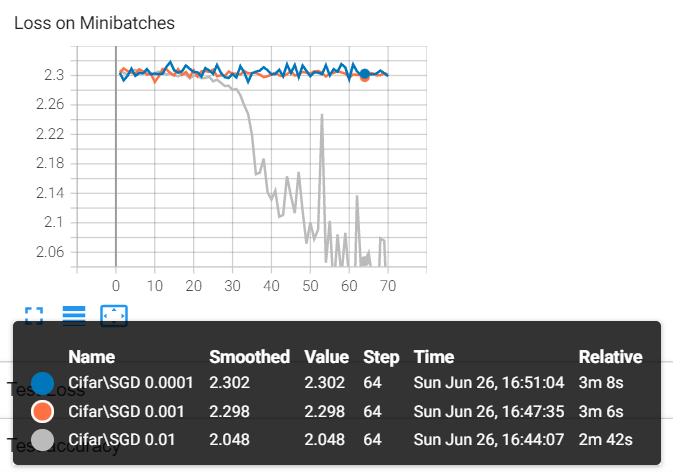

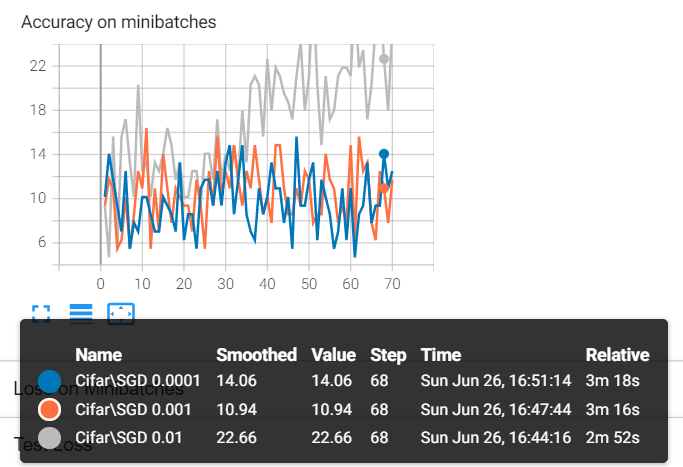

# Training and Test Loss

### SGD seems to work better with not too small initial learning rate and afterwards a small learning rate there is hardly any much declination in the loss.

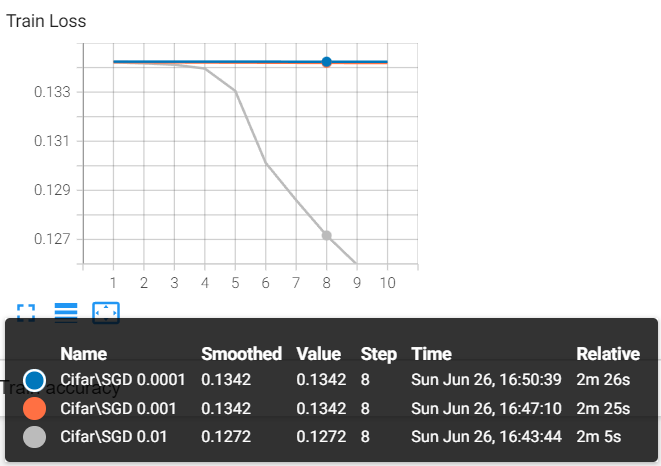

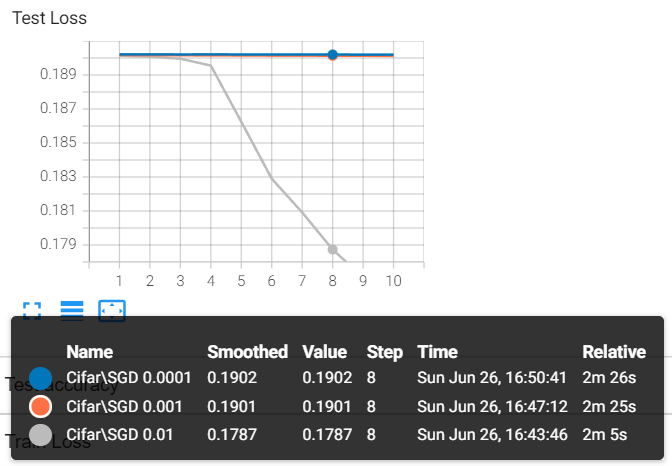

# Training and Test Accuracy

### As seen above for loss same applies to accuracy.

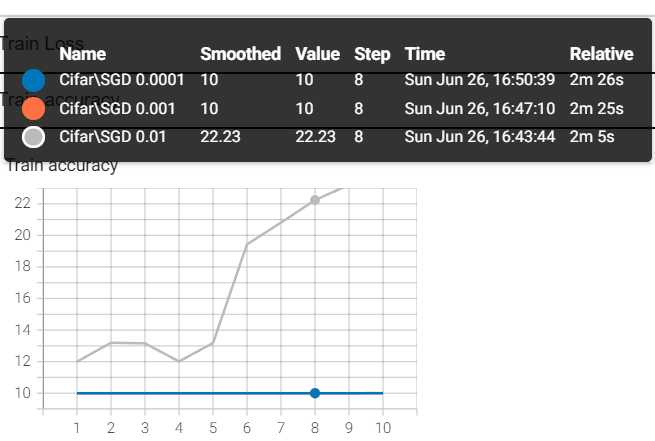

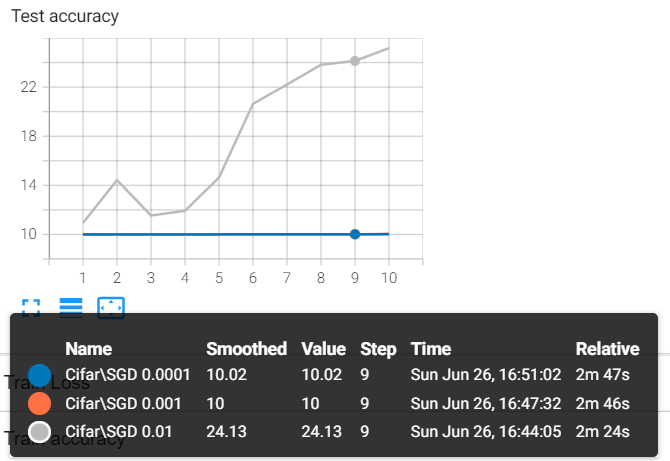